In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

import torch

from pathlib import Path
from models.unet import *
from utils.plot import *
from utils.data_loader import *

In [3]:
CT_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\studies\CT-1")
MASK_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\masks")

In [4]:
ds = CTSlices(CT_DIR, MASK_DIR)

In [5]:
model = UNet(n_channels=1, kernel_size=3, ds=16).cuda()

In [6]:
dataloader = DataLoader(
    ds, 
    batch_size=8,                   
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)

In [7]:
N_EPOCHS = 500
learning_rate = 1e-4
WEIGHT_DIR = Path("weights")
if not WEIGHT_DIR.exists():
    WEIGHT_DIR.mkdir(parents=True)

In [8]:
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=learning_rate,
    total_steps=N_EPOCHS * len(dataloader),
    cycle_momentum=True,
)

def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return -(numerator + 1) / (denominator + 1)

loss_obj = dice_loss

  0%|▏                                                                 | 1/500 [00:26<3:43:02, 26.82s/it, loss=-0.0083]

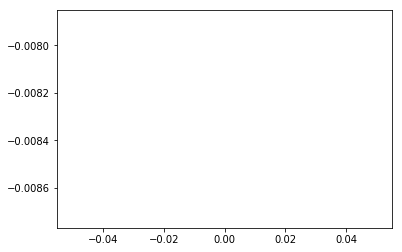

  2%|█▍                                                               | 11/500 [04:56<3:39:12, 26.90s/it, loss=-0.0079]

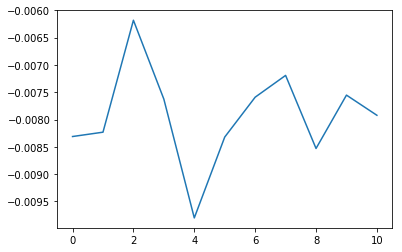

  4%|██▋                                                              | 21/500 [09:29<3:38:22, 27.35s/it, loss=-0.0089]

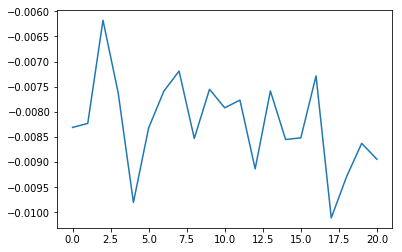

  6%|████                                                             | 31/500 [13:55<3:28:00, 26.61s/it, loss=-0.0070]

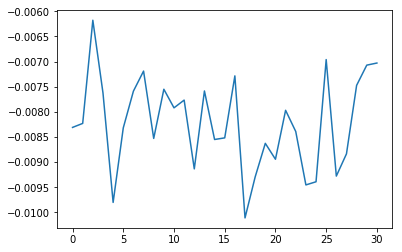

  8%|█████▎                                                           | 41/500 [18:25<3:26:25, 26.98s/it, loss=-0.0088]

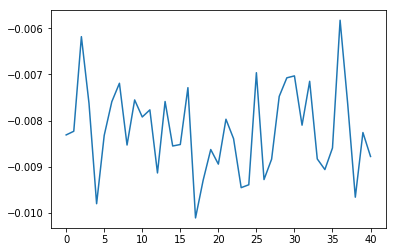

 10%|██████▋                                                          | 51/500 [22:52<3:17:54, 26.45s/it, loss=-0.0082]

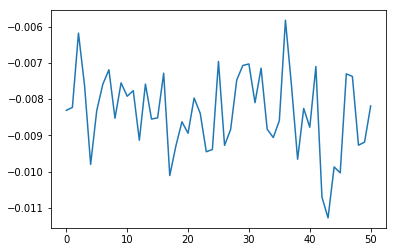

 12%|███████▉                                                         | 61/500 [27:16<3:13:10, 26.40s/it, loss=-0.0076]

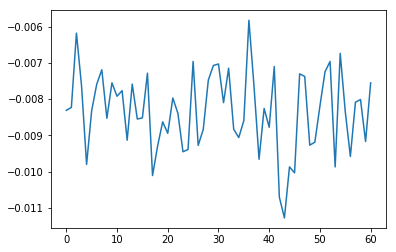

 14%|█████████▏                                                       | 71/500 [31:47<3:12:37, 26.94s/it, loss=-0.0084]

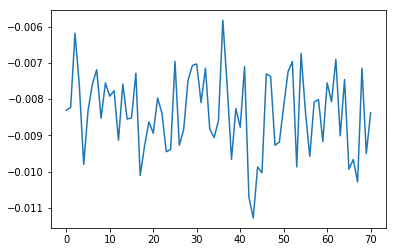

 16%|██████████▌                                                      | 81/500 [36:17<3:08:08, 26.94s/it, loss=-0.0104]

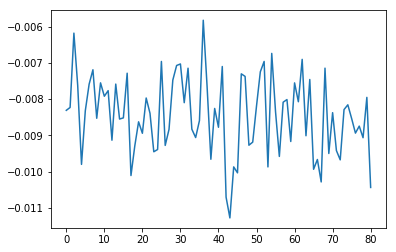

 18%|███████████▊                                                     | 91/500 [40:47<3:02:46, 26.81s/it, loss=-0.0094]

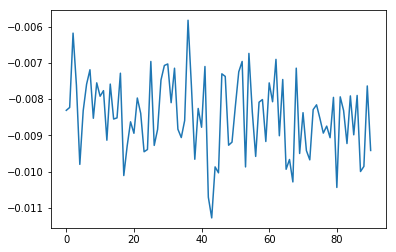

 20%|████████████▊                                                   | 100/500 [45:13<3:00:55, 27.14s/it, loss=-0.0085]


KeyboardInterrupt: 

In [9]:
losses = []
with tqdm(total=N_EPOCHS) as pbar:
    for cur_epoch in range(N_EPOCHS):
        epoch_loss = 0

        for xs, ys in dataloader:
            opt.zero_grad()
            
            ys_hat = model(xs)
            loss = dice_loss(ys_hat, ys)
            loss.backward()
            opt.step()
            scheduler.step()
            
            epoch_loss += loss.detach().cpu().numpy()
            
        # Progress bar update

        losses.append(epoch_loss / len(dataloader))

        pbar.set_postfix(
            {
                'loss': '{:.4f}'.format(losses[-1]),
#                 'cur_lr': scheduler.get_last_lr()[0],
            }
        )
        pbar.update(1)

        if cur_epoch % 10 == 0:
            plt.plot(losses)
            plt.show()

            WEIGHT_PATH = WEIGHT_DIR / "weights_epoch_{}.h5".format(cur_epoch)
            torch.save(
                {
                    'model': model.state_dict(),
                    'opt': opt.state_dict(),
                },
                str(WEIGHT_PATH),
            )

In [ ]:
multiplot([
    xs[0,0].detach().cpu().numpy(),
    ys[0,0].detach().cpu().numpy(),
    ys_hat[0,0].detach().cpu().numpy(),
])

In [ ]:
cur_epoch


In [ ]:
WEIGHT_PATH = WEIGHT_DIR / "weights_epoch_{}.h5".format(cur_epoch+1)
torch.save(
    {
        'model': model.state_dict(),
        'opt': opt.state_dict(),
    },
    str(WEIGHT_PATH),
)